1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

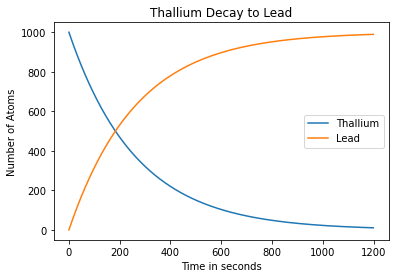

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import math

#probability of decay after time t
def p(t):
    tau = 3.052 * 60 #half life in seconds
    return 1-(2**(-t/tau))
    #return (2**(-t/tau))*(math.log(2)/tau)
tmax = 1200
th_atom = 1000
t = np.arange(0,tmax,1)
Thallium = np.full(tmax, th_atom)
lead = p(t)*Thallium
#print(thal)
thal = Thallium - lead

th_decay = plt.figure()
plt.plot(thal, label = 'Thallium')
plt.plot(lead, label = 'Lead')
plt.title('Thallium Decay to Lead')
plt.xlabel('Time in seconds')
plt.ylabel('Number of Atoms')
plt.legend()
plt.show()
########################################################################


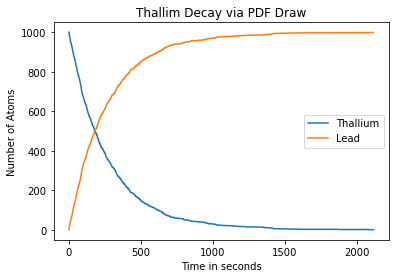

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import math

def t(z):
    tau = 3.052*60
    a = math.log(1-z)
    b = math.log(2)
    return -a*tau/b
particles = 1000
decaytimes = np.empty(particles)
for i in range(particles):
    z = np.random.rand()
    decaytimes[i] = t(z)

decaytimes.sort()
#plt.hist(decaytimes, bins = 50)
#plt.xlim(0,1000)

tmax = math.ceil(np.max(decaytimes))
thal = particles
lead = 0
time = np.arange(0,tmax,1)
th = np.empty(len(time))
le = np.empty(len(time))
for t in range(tmax):
    th[t] = thal
    le[t] = lead
    
    mask = decaytimes < t+1
    mask2 = t < decaytimes[mask]
    
    dec = decaytimes[mask][mask2]
    
    decayed = len(dec)
    thal = thal - decayed
    lead = lead + decayed
    
plt.plot(th, label = 'Thallium')
plt.plot(le, label = 'Lead')
plt.xlabel('Time in seconds')
plt.ylabel('Number of Atoms')
plt.title('Thallim Decay via PDF Draw')
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [43]:
import math
import scipy.constants as const
import numpy as np
import numpy.random as npr

def angle(b):
    Z = 79
    esq = (const.elementary_charge)**2
    E = 7.7 * 1.6e-19
    e0 = 8.8541878128e-12
    pi = math.pi
    
    return np.arctan((Z*esq)/(2*pi*e0*E*b))*2

no_alpha = 1000000
a0 = 5.29177210903e-11
x = npr.normal(size = no_alpha, scale = a0/100)
y = npr.normal(size = no_alpha, scale = a0/100)

b = np.sqrt(x**2+y**2)
angles = angle(b)

mask = angles > math.pi/2
print(angles)
fraction = np.sum(mask)/no_alpha
print('fraction deflected',fraction)

print('I am not sure why all my scattering angles are soo big. The smallest is:', np.min(angles), 'radians')

print("I checked the constants and math a hundred times and compaired with others, it all seems fine. I can't find the problem")

[3.14151948 3.141523   3.14158376 ... 3.14158418 3.14156859 3.14151083]
fraction deflected 1.0
I am not sure why all my scattering angles are soo big. The smallest is: 3.141399033753617 radians
I checked the constants and math a hundred times and compaired with others, it all seems fine. I can't find the problem


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

<class 'numpy.ndarray'>
The max of the function is: <function f at 0x7fba0eb82b80> So I will define my box from 0 to 2 on x axis and 0 to 1 on y axis
under: 7172 
over: 2828 
Area under: 1.4344
Using this method I estimated the integration 100 times. The mean estimation is: 1.4518
The standard error on this mean is: 0.0009


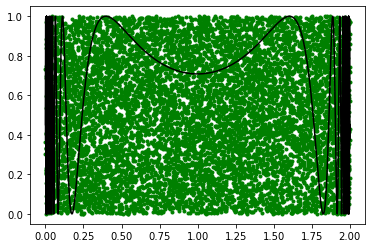

In [80]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
def f(x):
    return np.sin(1/(x*(2-x)))**2

res = 10000

x = np.linspace(0.001,1.999,res)
print(type(x))

fun = np.array([f(x) for x in x])

print('The max of the function is:',np.max(f),'So I will define my box from 0 to 2 on x axis and 0 to 1 on y axis')


rx = npr.rand(res)*2 # generates a random number from 0 to 2
ry = npr.rand(res)

plt.scatter(rx,ry,marker = '.', color = 'g')
plt.plot(x,fun, color = 'black')


frx = np.array([f(i) for i in rx])

under = 0
over = 0
for y, fun in zip(ry,frx):
    if y < fun:
        under += 1
    elif y > fun:
        over += 1
print('under:',under,'\nover:',over,'\nArea under:',2*(under/res))

n = 100
areas = np.empty(n)
for i in range(n):
    rx = npr.rand(res)*2 # generates a random number from 0 to 2
    ry = npr.rand(res)
    frx = np.array([f(i) for i in rx])
    under = 0
    over = 0
    for y, fun in zip(ry,frx):
        if y < fun:
            under += 1
        elif y > fun:
            over += 1
    areas[i] = 2*under/res

print('Using this method I estimated the integration 100 times. The mean estimation is:',round(np.mean(areas),4))
print('The standard error on this mean is:', round(np.std(areas)/np.sqrt(n),4))




In [18]:
#ask for help
##mean value method
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
a = 0.001
b = 1.999
res = 10000
def f(x):
    return np.sin(1/(x*(2-x)))**2

x = npr.rand(res)*2
#x = np.linspace(a,b,res)
fx = np.array(list(map(f,x)))

I = ((b-a)/res)*np.sum(fx)

std = (b-a)*(np.sqrt(np.var(fx))/np.sqrt(res))

print('The area under is estimated to be',round(I,3),'With a standard error of',round(std,3))
#not sure why this method is massivly underestimating the error

1.453663806503329
0.0052832504325347395
The area under is estimated to be 1.454 With a standard error of 0.005



<h1>Comparison</h1>

Using the hit/miss method I estimated the integration 100 times. 
The mean estimation is: 1.4518
The standard error on this mean is: 0.0009

Using the mean value method
The area under is estimated to be 1.454 With a standard error of 0.005

Hit/miss    1.4518 $\pm$ 0.0009<br>
mean value  1.454  $\pm$ 0.005

These values agree with eachother

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



The area inside is pi, 3.14... It is estimated at: 3.1004


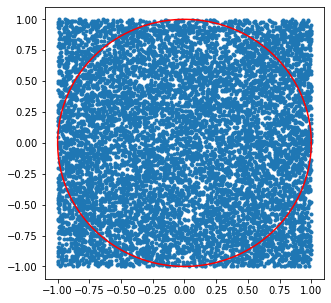

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr

##we don't know the formula for a multidimensional sphere volume so use a box instead of a circle
d = 2#number of dimensions
res = 10000
theta = np.linspace(0,2*math.pi,res)
def f(r):
    ans = 0
    if abs(r) <= 1:
        ans = 1
    return ans

randx = npr.random(res)*2-1
randy = npr.random(res)*2-1
randr = np.sqrt(randx**2+randy**2)



r = 1
x = np.array(list(map(lambda th: r*math.cos(th),theta)))
y = np.array(list(map(lambda th: r*math.sin(th),theta)))

r = 1.1
x2 = np.array(list(map(lambda th: r*math.cos(th),theta)))
y2 = np.array(list(map(lambda th: r*math.sin(th),theta)))

circles = plt.figure(figsize = (5,5))

plt.scatter(randx,randy, marker = '.')
plt.plot(x,y, color = 'red')

inside = np.count_nonzero(np.array(list(map(f,randr))))
outside  = res - inside

areaInside = (inside/res)*2**d

print('The area inside is pi, 3.14... It is estimated at:',areaInside)





In [19]:
res = 1000000
def ndsphere(d):
    points = npr.rand(res,d)
    r = np.sqrt(np.sum(points**2, axis = 1))
    inside = np.count_nonzero(r<1)
    volume = (inside/res)*2**d
    print('The volume of a (',d,'D) sphere of radius 1 is approximatly:',volume)


ndsphere(10)
    
        


The volume of a ( 10 D) sphere of radius 1 is approximatly: 2.494464


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [15]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
res = 100000

x = np.linspace(0.0001,1,res)


f = x**(-1/2)/(np.exp(x)+1)
w = 1/np.sqrt(x)

I_w = (1/res)*np.sum(w)


I = (1/res)* np.sum(f/w)*I_w

print('The area is',I)

print('Not sure why my value is soo different. I checked my use of the formula many times.')


0.7524107024665107
